In [1]:
def _ensure_import(modname: str, pip_spec: str = None, tag: str = None, extra_pip_args=()):
    """
    Try to import `modname`. If it fails, pip-install `pip_spec` into /tmp cache,
    add to sys.path, and import again. `tag` is used to make the cache path deterministic.
    """
    try:
        return __import__(modname)
    except ImportError:
        pass

    base = os.environ.get("ZJET_CACHE_BASE", "/tmp/zjet_pkgs")
    tag = tag or modname
    target = os.path.join(base, tag.replace("/", "_"))
    os.makedirs(target, exist_ok=True)

    # crude file lock so many workers don't fight (best-effort)
    lock = os.path.join(target, ".install.lock")
    try:
        fd = os.open(lock, os.O_CREAT | os.O_EXCL | os.O_WRONLY)
        os.close(fd)
        # We won the "lock": perform install if not already present
        marker = os.path.join(target, ".done")
        if not os.path.exists(marker):
            cmd = [sys.executable, "-m", "pip", "install", "--no-deps", "-q", "--target", target, pip_spec]
            if extra_pip_args:
                cmd[6:6] = list(extra_pip_args)
            code = subprocess.call(cmd)
            if code != 0:
                raise RuntimeError(f"pip install failed for {pip_spec} (exit {code})")
            # mark success
            with open(marker, "w") as f:
                f.write("ok")
    except FileExistsError:
        # someone else is installing; wait briefly
        import time
        for _ in range(120):
            if os.path.exists(os.path.join(target, ".done")):
                break
            time.sleep(0.5)
    finally:
        try:
            os.remove(lock)
        except OSError:
            pass

    if target not in sys.path:
        sys.path.insert(0, target)
    return __import__(modname)

In [2]:
import coffea
import numpy as np
import awkward as ak
import uproot
import pickle
import os, sys, subprocess, json, gzip, correctionlib
import time
#sys.path.append(os.path.join(os.getcwd(), "src/zjet_corrections"))
import sys, os
sys.path.insert(0, os.path.abspath("/work")) 
import importlib
zjet_corrections = _ensure_import("zjet_corrections")
import zjet_corrections.zjet_processor

importlib.reload(zjet_corrections.zjet_processor)

from zjet_corrections.zjet_processor import QJetMassProcessor
from coffea.nanoevents import NanoAODSchema
from coffea import processor


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
NanoAODSchema.warn_missing_crossrefs = False



def make_runner(
    use_dask: bool = False,
    client=None,
    workers: int = 1,
    chunksize: int = 400_000,
    maxchunks: int | None = 1,
    skipbadfiles: bool = True,
):
    """
    If use_dask=True, 'client' must be an existing distributed.Client.
    Otherwise falls back to FuturesExecutor(workers=...).
    """
    if use_dask:
        if client is None:
            raise ValueError("use_dask=True but no Dask 'client' was provided.")
        executor = processor.DaskExecutor(
            client=client,
            status=True,      # progress bar
            retries=1,        # re-try failed chunks
        )
    else:
        executor = processor.FuturesExecutor(
            workers=workers,
            status=True,      # progress bar
            compression=None, # keep your original choice
        )

    return processor.Runner(
        executor=executor,
        schema=NanoAODSchema,
        chunksize=chunksize,
        maxchunks=maxchunks,
        skipbadfiles=skipbadfiles,
    )

# -------------------------
# Usage (Futures locally):
# -------------------------
# run = make_runner(use_dask=False, workers=1, chunksize=100000, maxchunks=None)
# out = run(fileset, "Events", processor_instance=ZmmMinimal())

In [5]:
os.getcwd()

'/home/cms-jovyan/new_git/zjet_corrections/tests'

In [6]:
os.getcwd()

'/home/cms-jovyan/new_git/zjet_corrections/tests'

In [7]:
#prependstr = 'root://xcache/'
prependstr = "root://cmsxrootd.fnal.gov/"
with open('samples.txt') as f:
    lines = f.readlines()
files = []
for line in lines:
    files.append(prependstr + line[:-1])
fileset = {
    'DYJetsToLL_M-50': files

}

In [8]:
from dask.distributed import Client

client = Client("tls://192.168.202.36:8786")
client

<Client: 'tls://192.168.202.36:8786' processes=1 threads=1, memory=2.89 GiB>

In [9]:
os.getcwd()

'/home/cms-jovyan/new_git/zjet_corrections/tests'

In [10]:
import shutil, os, pathlib

pkg_dir = pathlib.Path("/home/cms-jovyan/new_git/zjet_corrections/src/zjet_corrections")   # or the actual path to your package dir
zip_path = pathlib.Path("/tmp/zjet_corrections.zip")
if zip_path.exists():
    zip_path.unlink()
shutil.make_archive(zip_path.with_suffix(""), "zip", pkg_dir.parent, pkg_dir.name)

client.upload_file(str(zip_path))  # uploads the zip and adds it to workers' sys.path

{'tls://129.93.182.116:45587': {'status': 'OK'}}

In [ ]:
#fileset_test = {"DYJets":["/work/ws/zjet_corrections/tests/DYjets.root"]}
fileset_test = {list(fileset.keys())[0]:[fileset[list(fileset.keys())[0]][0]]}
run = make_runner(use_dask=True, client=client, chunksize=100000, maxchunks=None)
t0 = time.time()
out = run(fileset_test, "Events", processor_instance=QJetMassProcessor(debug=True))
t1 = time.time()
print(f"Done Running, time taken {(t1-t0):.2f} seconds")

[########################                ] | 60% Completed |  1min 53.3s

(0.0, 200.0)

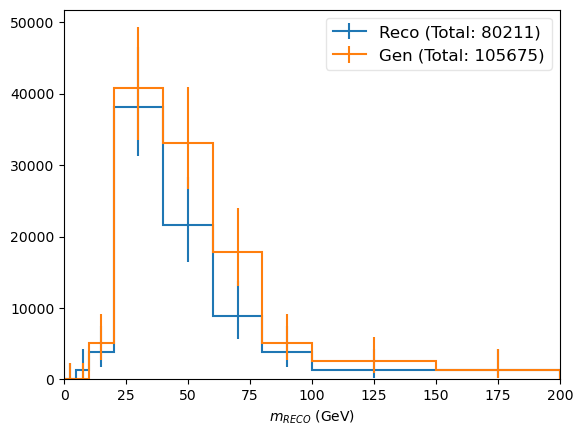

In [13]:
import hist
import matplotlib.pyplot as plt
h1 = out['ptjet_mjet_u_reco'].project('mreco')[hist.rebin(2)]
h2 = out['ptjet_mjet_u_gen'].project('mgen')[hist.rebin(1)]
h1.plot(label='Reco')
h2.plot(label='Gen')
plt.legend()
total_reco = h1.sum().value
total_gen = h2.sum().value
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
new_labels = []
for lab in labels:
    if lab == 'Reco':
        new_labels.append(f"Reco (Total: {total_reco:.0f})")
    elif lab == 'Gen':
        new_labels.append(f"Gen (Total: {total_gen:.0f})")
    else:
        new_labels.append(lab)
ax.legend(handles, new_labels, loc='best', fontsize=12, framealpha=0.5)
#plt.yscale('log')
plt.xlim(0,200)

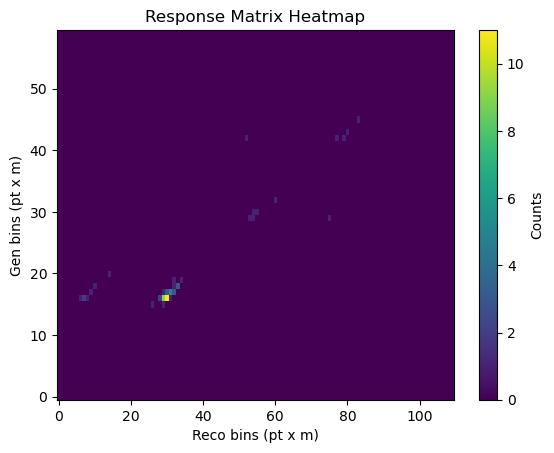

In [14]:
h_resp = out['response_matrix_u'].project('ptgen', 'mgen', 'ptreco', 'mreco')
resp_vals = h_resp.values(flow = True)
resp_vals_2d = resp_vals.reshape(resp_vals.shape[0]*resp_vals.shape[1], resp_vals.shape[2]*resp_vals.shape[3])
plt.imshow(resp_vals_2d, origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Counts')
plt.xlabel('Reco bins (pt x m)')
plt.ylabel('Gen bins (pt x m)')
plt.title('Response Matrix Heatmap')
plt.show()

In [10]:
resp_vals.sum(axis= (0,1,3))

array([ 8., 43., 13.,  6.,  0.])

In [11]:
import pickle
with open("test_output.pkl", "wb") as f:
    pickle.dump(out, f)
print(f"Output written to test_output.pkl with size {os.path.getsize('test_output.pkl')/1e3:.1f} KB")

Output written to test_output.pkl with size 219.2 KB
